<a href="https://colab.research.google.com/github/Kyrylo-Bakumenko/TARC/blob/master/AltitiudeLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from filterpy.kalman import FixedLagSmoother, KalmanFilter
import numpy.random as random

def kf_smooth(zs):
  fls = FixedLagSmoother(dim_x=2, dim_z=1, N=10)

  fls.x = np.array([0., .5])
  fls.F = np.array([[1.,1.],
                    [0.,1.]])

  fls.H = np.array([[1.,0.]])
  fls.P *= 200
  fls.R *= 5.
  fls.Q *= 0.001

  kf = KalmanFilter(dim_x=2, dim_z=1)
  kf.x = np.array([0., .5])
  kf.F = np.array([[1.,1.],
                  [0.,1.]])
  kf.H = np.array([[1.,0.]])
  kf.P *= 200
  kf.R *= 5.
  kf.Q *= 0.001

  N = 4 # size of lag

  # nom =  df['Time'][1:]
  # zs = df.Altitude[1:]
  # zs = df.Velocity[1:]

  for z in zs:
      fls.smooth(z)
      
  kf_x, _, _, _ = kf.batch_filter(zs)
  x_smooth = np.array(fls.xSmooth)[:, 0]

  return x_smooth, kf_x[:, 0]

In [ ]:
# time
# t - 1
# acc
# acc - 1
# alt
# alt - 1

data = pd.read_csv('/content/TARC Rocket lauch - pnut_data.csv')
data.drop(labels=['date', 'temp_orig', 'temp', 'volt', 'flight_time', 'date_flight'], axis='columns', inplace=True)
# flight #1 was a failure
flight_1 = data[data.flight == 2][data.alt > 0].reset_index().drop(labels=['index'], axis = 1)
flight_2 = data[data.flight == 3].reset_index().drop(labels=['index'], axis = 1)
flight_3 = data[data.flight == 4].reset_index().drop(labels=['index'], axis = 1)
print(flight_1.head(), '\n\n', flight_2.head(), '\n\n', flight_3.head())


   flight  time  alt
0       2  0.00    1
1       2  0.15    1
2       2  0.20    1
3       2  0.30    1
4       2  0.45    1 

    flight  time  alt
0       3  0.00    0
1       3  0.05    0
2       3  0.10    0
3       3  0.15    0
4       3  0.20    0 

    flight  time  alt
0       4  0.00   -2
1       4  0.05   -1
2       4  0.10   -1
3       4  0.15    0
4       4  0.20    0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
alt_smooth, _ = kf_smooth(flight_1.alt)
flight_1.alt = alt_smooth
flight_1.rename({'alt' : 'alt_smooth'}, inplace=True, axis = 1)
flight_1

,flight,time,alt_smooth
0,2,0.00,0.993827
1,2,0.15,1.033509
2,2,0.20,1.016268
3,2,0.30,0.996657
4,2,0.45,0.973258
...,...,...,...
541,2,27.45,8.136769
542,2,27.50,6.267821
543,2,27.55,4.398069
544,2,27.60,2.525313


In [ ]:
def pva(pos, vel, acc):
  dT = abs(vel/acc)
  return pos + vel*dT + 0.5*acc*dT**2

def Apogee(t0, t1, t2, p0, p1, p2, a=None, a1=None):
  dT1 = t0-t1
  v1 = (p0-p1)/dT1
  if not a:
    dT2 = t1-t2
    v2 = (p1-p2)/dT2
    a1 = (v1-v2)/dT2
  # print(p0, v1, a1)
  return pva(p0, v1, a1)

In [ ]:
flight_1['time1'] = flight_1.time.shift(4)
flight_1['time2'] = flight_1.time.shift(8)
flight_1['alt_smooth1'] = flight_1.alt_smooth.shift(4)
flight_1['alt_smooth2'] = flight_1.alt_smooth.shift(8)

In [ ]:
flight_1['Apogee'] = flight_1.apply(lambda r: Apogee(r['time'], r['time1'], r['time2'], r['alt_smooth'], r['alt_smooth1'], r['alt_smooth2']), axis=1)

In [ ]:
flight_1

,flight,time,alt_smooth,time1,time2,alt_smooth1,alt_smooth2,Apogee
0,2,0.00,0.993827,NaN,NaN,NaN,NaN,NaN
1,2,0.15,1.033509,NaN,NaN,NaN,NaN,NaN
2,2,0.20,1.016268,NaN,NaN,NaN,NaN,NaN
3,2,0.30,0.996657,NaN,NaN,NaN,NaN,NaN
4,2,0.45,0.973258,0.00,NaN,0.993827,NaN,NaN
...,...,...,...,...,...,...,...,...
541,2,27.45,8.136769,27.25,27.05,15.939137,23.210535,-163.841538
542,2,27.50,6.267821,27.30,27.10,13.962604,21.244956,-209.076328
543,2,27.55,4.398069,27.35,27.15,11.967186,19.866312,-82.405157
544,2,27.60,2.525313,27.40,27.20,10.035654,17.926133,-71.665281


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


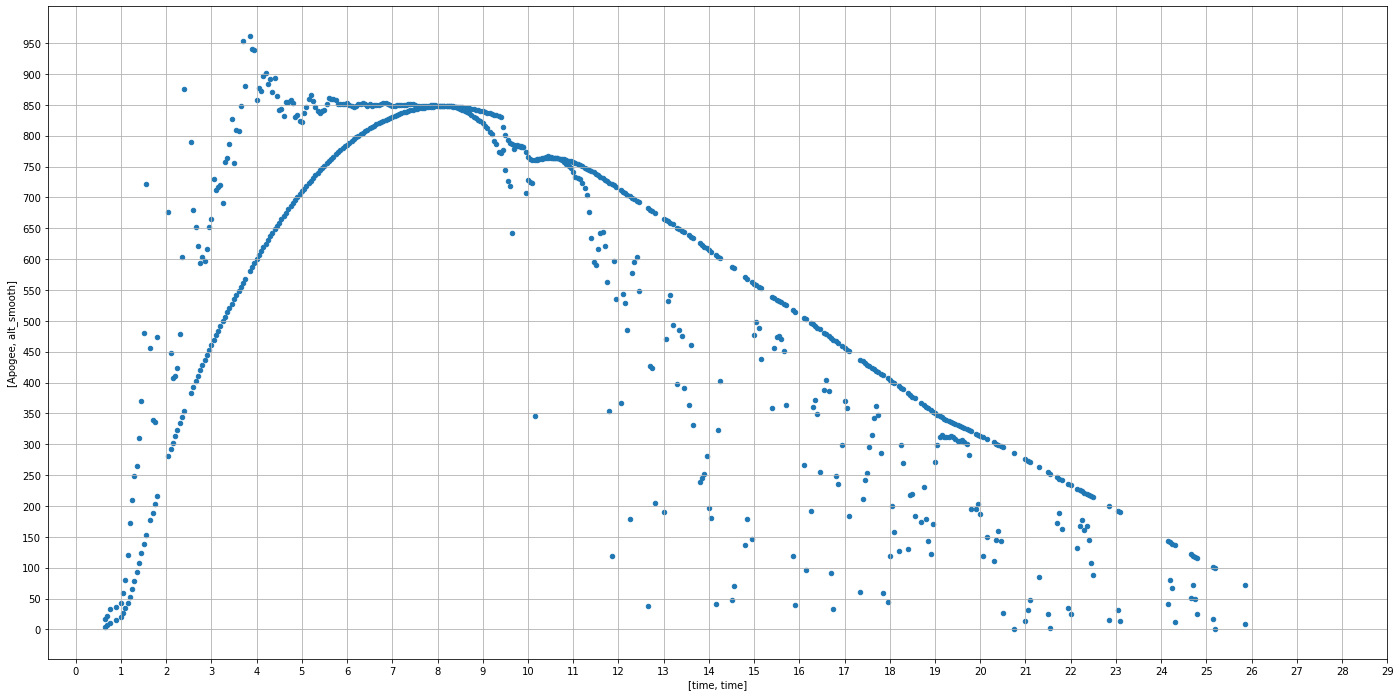

In [ ]:
flight_1[flight_1['Apogee'] < 1000][flight_1['Apogee'] > 0].plot(['time', 'time'], ['Apogee', 'alt_smooth'],
                                                           grid=True, figsize=(24, 12), kind='scatter',
                                                           xticks=range(0, 30, 1),yticks=range(0, 1000, 50))
# flight_1[flight_1['Apogee'] < 1000][flight_1['Apogee'] > 0].plot('time', 'Apogee',
#                                                            grid=True, figsize=(12, 8), kind='scatter',
#                                                            colormap = 'jet')
# flight_1[flight_1['Apogee'] < 1000][flight_1['Apogee'] > 0].plot('time','alt_smooth',
#                                                            grid=True, figsize=(12, 8), kind='scatter',
#                                                            colormap = 'jet')